In [101]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib as pl
import seaborn as sns
%matplotlib inline

# Análise Exploratória

Vamos começar lendo o conjunto de dados e definindo o nome correto para suas colunas. Além disso, vamos criar dois conjuntos de dado ¨de apoio¨, um contendo apenas variáveis discretas/categóricas e outro com as variáveis contínuas.

In [102]:
## Reading .csv files
df = pd.read_csv("data/corrected.csv",sep=',',header=None)

## Defining columns
col_names = pd.read_csv("data/column_names.csv",sep=',',header=None)[0].values
df.columns = col_names

## Identifying columns as categorical or not
categorical_columns = ["protocol_type","service","flag","land","logged_in","root_shell","su_attempted",
                       "is_host_login","is_guest_login","label"]
df_categorical = df[categorical_columns]
df_non_categorical = df.drop(categorical_columns, axis=1)

In [103]:
## A glance at the non categorical data
df_non_categorical.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000762,0.000051,0.014677,0.002363,0.011243,0.008359,0.000958,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.040367,0.009821,0.312068,0.049990,1.958325,2.165196,0.193119,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,3.000000,3.000000,101.000000,4.000000,796.000000,878.000000,100.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Análise de variáveis discretas


### Relação entre Ataques e Serviços de Rede

Vamos começar analisando a relação entre o serviço de rede utilizado pelo destino dos pacotes e os ataques identificados. Para tal, vamos plotar um gráfico de barras que mostra o percentual de participação de cada serviço de rede em cada ataque.

**De modo a facilitar a visualização, vamos considerar apenas variáveis que representem ao menos 1% do percentual total de ataques ou tipos de serviço de rede.**



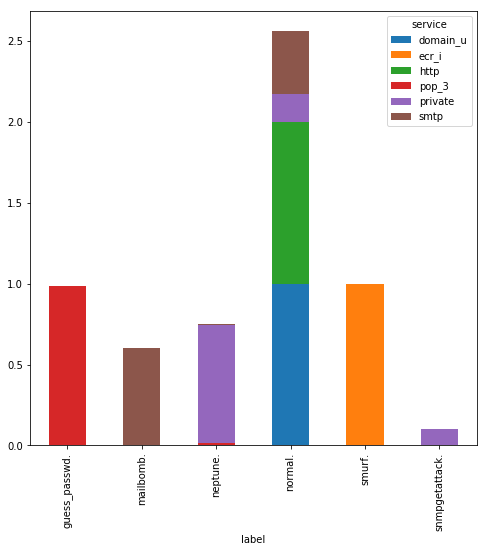

In [5]:
## Create a subset of main dataset (f_data) that contains only services and labels that represents at
## least 1% of the total cases

f_services = pd.crosstab(index=df["service"],columns="count")
f_services = f_services/len(df)
f_services = f_services[f_services["count"] > 0.01]

f_attacks = pd.crosstab(index=df["label"],columns="count")
f_attacks = f_attacks/len(df)
f_attacks = f_attacks[f_attacks["count"] > 0.01]

f_data = df[df['service'].isin(list(f_services.index))]
f_data = f_data[f_data['label'].isin(list(f_attacks.index))]

## Create the plot

attack_data = pd.crosstab(index = f_data["label"], columns=f_data["service"])
frequency_table_attack = (attack_data/attack_data.sum())

frequency_table_attack.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True);

### Relação entre Ataques e Tipos de Protocolo

Utilizando a mesma abordagem anterior, iremos avaliar o percentual de participcação de cada protocolo de rede em cada tipo de ataque.

O objetivo desse análise é visualziar se existe alguma característica que foge do conhecido pela literatura.

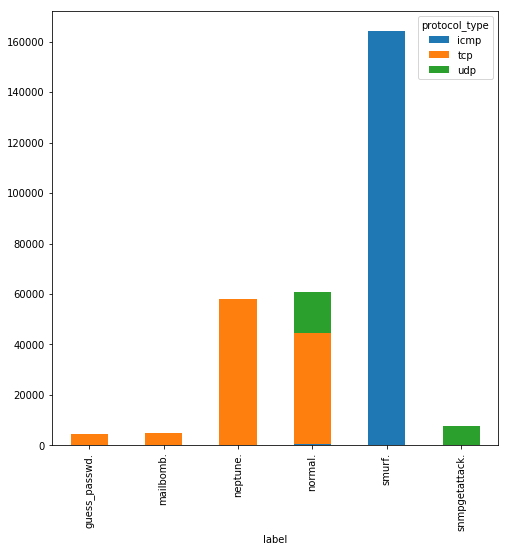

In [6]:
## Create a subset of main dataset (f_data) that contains only protocols and labels that represents at
## least 1% of the total cases

f_protocol = pd.crosstab(index=df["protocol_type"],columns="count")
f_protocol = f_protocol/len(df)
f_protocol = f_protocol[f_protocol["count"] > 0.01]

f_data = df[df['protocol_type'].isin(list(f_protocol.index))]
f_data = f_data[f_data['label'].isin(list(f_attacks.index))]

## Create a Two-Way Table

relationship_protocoal_attack = pd.crosstab(index=f_data["label"], 
                          columns=f_data["protocol_type"])
## Plot the Two-Way Table
relationship_protocoal_attack.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True);

### Participação percentual de cada tipo de protocolo de rede

O gráfico abaixo visa dar uma visão geral da participação de cada tipo de protocolo na rede na qual os dados foram coletados.

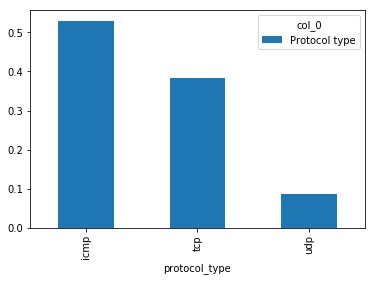

In [7]:
## Create a cross tab dataframe
protocol_data = pd.crosstab(index = df["protocol_type"],columns="Protocol type")
frequency_table_protocol = (protocol_data/protocol_data.sum())

## Plot the dataframe
frequency_table_protocol.plot.bar();

## Análise de variáveis contínuas

### Histogramas

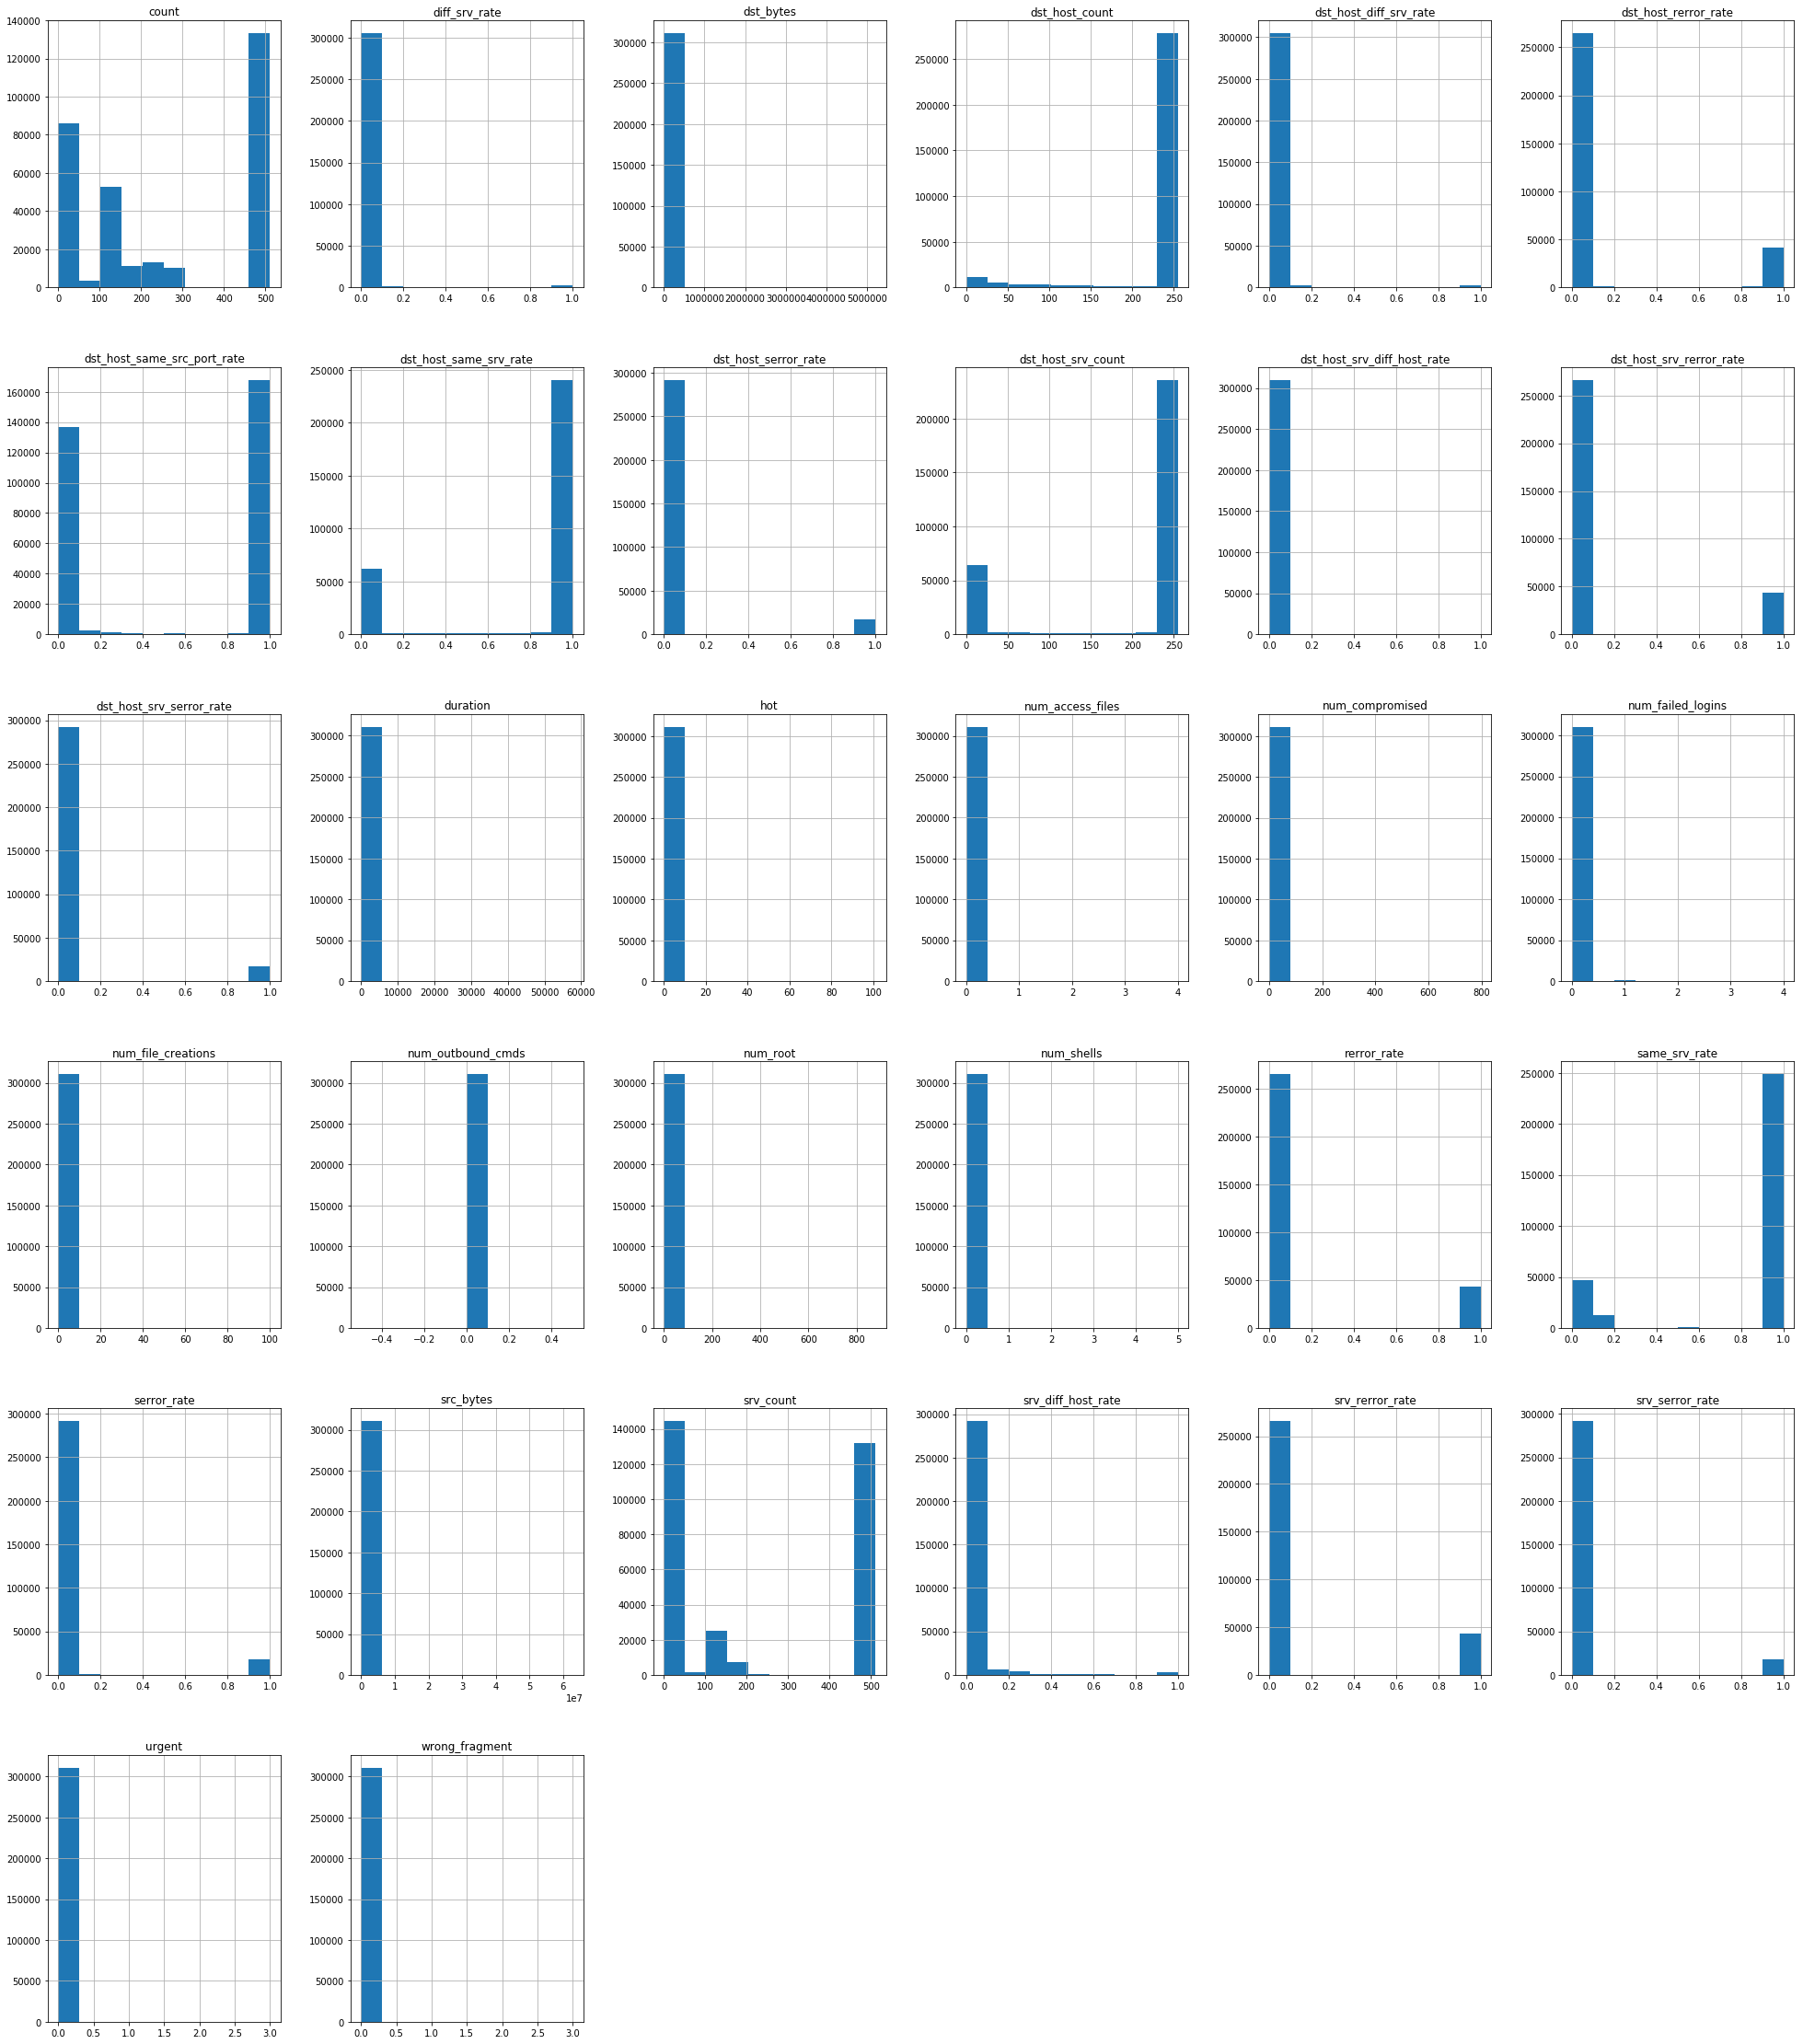

In [8]:
df_non_categorical.hist(figsize = (34,40));

### Análise dos usuários logados no sistema

Julgamos interessante avalair o padrão de comportamento dos usuários que de alguma forma estão logados na rede. Dessa forma, iremos criar gráficos que analisam se alguma ameaça foi detectada para os seguintes tipos de usuários: usuários simplesmente logados, usuários logados como host, usuários logados como convidados.

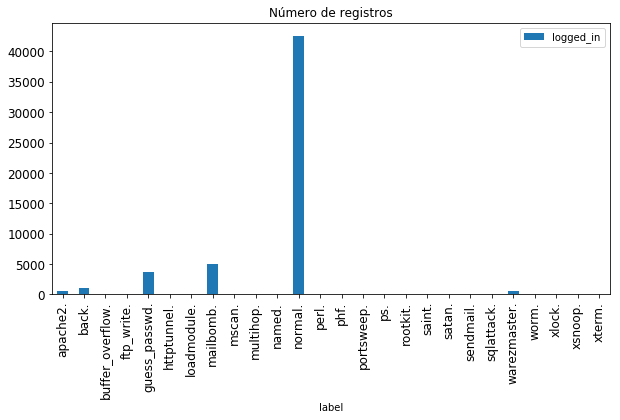

In [41]:
df_temp = df[["logged_in","label"]]
df_temp = df_temp.loc[df_temp['logged_in'] == 1]
df_temp.groupby(["label"]).count().plot(kind='bar', title ="Número de registros", figsize=(10, 5), legend=True, fontsize=12)

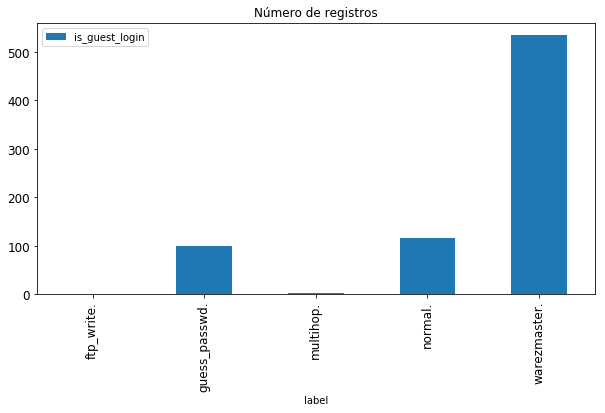

In [45]:
df_temp = df[["is_guest_login","label"]]
df_temp = df_temp.loc[df_temp['is_guest_login'] == 1]
df_temp.groupby(["label"]).count().plot(kind='bar', title ="Número de registros", figsize=(10, 5), legend=True, fontsize=12)

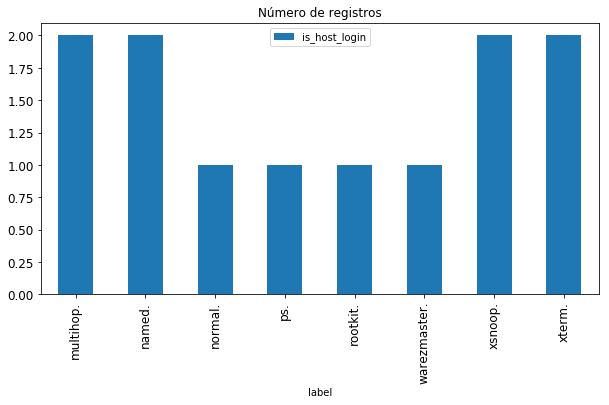

In [43]:
df_temp = df[["is_host_login","label"]]
df_temp = df_temp.loc[df_temp["is_host_login"] == 1]
df_temp.groupby(["label"]).count().plot(kind='bar', title ="Número de registros", figsize=(10, 5), legend=True, fontsize=12)


## Análise de dados redundantes

De acordo com Tavallaee (2009), o grande número de registros redundantes pode enviesar os classificadores para os registros mais frequentes. Desssa forma, o autor propõe um novo dataset, removendo as duplicatas. Dessa forma, analisaremos o dataset KDD99 completo e o sem as duplicatas. Para tal analisaremos a razão entre os dados únicos e os duplicados e plotaremos os gráficos de relação entre os ataques e serviços, e entre os ataques e protocolos utilizados.

In [3]:
df2 = df.drop_duplicates()
percentage = 1 - float(df2.shape[0])/float(df.shape[0])
print("O dataset sem duplicatas é {}% menor que o dataset original".format(percentage * 100))

O dataset sem duplicatas é 75.14990563580888% menor que o dataset original


In [21]:
#Mapping strings to int
c1 = df.protocol_type.unique()
c2 = df.service.unique()
c3 = df.flag.unique()

d_protocol = {}
d_service = {}
d_wtver = {}
for i in range(len(c1)):
    d_protocol[c1[i]] = i

for i in range(len(c2)):
    d_service[c2[i]] = i
    
for i in range(len(c3)):
    d_wtver[c3[i]] = i

for i in d_protocol:
    df = df.replace(i, d_protocol[i])
for i in d_service:
    df = df.replace(i, d_service[i])
for i in d_wtver:
    df = df.replace(i, d_wtver[i])
    
    

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(df.iloc[:,:41], df[41])
p = clf.predict(df.iloc[:,:41])

# Modelos de classificação

## Random Forest

In [104]:
from sklearn.ensemble import RandomForestClassifier

X = df
X.loc[df.label != 'normal.'] = 1
X.loc[df.label == 'normal.'] = 0
Y = pd.factorize(X['label'])[0]
X = X.drop('label', 1)
randomForest = RandomForestClassifier()
randomForest.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

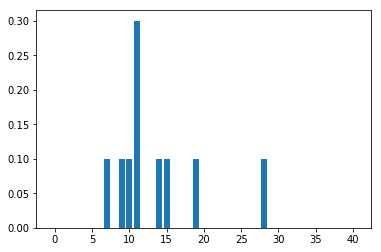

As 5 features mais relevantes para o modelo foram: 

logged_in, com influência: 0.3
wrong_fragment, com influência: 0.1
hot, com influência: 0.1
num_failed_logins, com influência: 0.1
su_attempted, com influência: 0.1


In [105]:
featuresImportance = {}
for i in range(len(df.columns[:len(df.columns)-1])):
    featuresImportance[df.columns[:len(df.columns)-1][i]] = randomForest.feature_importances_[i]
plt.bar(range(len(featuresImportance)), featuresImportance.values(), align='center')
plt.show()

s = [(k, featuresImportance[k]) for k in sorted(featuresImportance, key=featuresImportance.get, reverse=True)]

print("As 5 features mais relevantes para o modelo foram: \n")
for i in range (5):
    print("%s, com influência: %s" % (s[i][0],s[i][1]))